<h1 style="color:darkblue; text-align:center;">Time Series Anomaly Detection for IoT Sensors</h1>

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

### Data preparation and Exploration

In [2]:
df = pd.read_csv("ec2_cpu_utilization_5f5533.csv")

In [3]:
df.head()

,timestamp,value
0,2014-02-14 14:27:00,51.846
1,2014-02-14 14:32:00,44.508
2,2014-02-14 14:37:00,41.244
3,2014-02-14 14:42:00,48.568
4,2014-02-14 14:47:00,46.714


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  4032 non-null   object 
 1   value      4032 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.1+ KB


In [5]:
df.isnull().sum()

timestamp    0
value        0
dtype: int64

In [6]:
df.describe()

,value
count,4032.000000
mean,43.110372
std,4.303565
min,34.766000
25%,39.296000
50%,42.918000
75%,46.006000
max,68.092000


In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by='timestamp')
df.set_index('timestamp', inplace=True)

In [8]:
duplicates = df.index.duplicated().sum()
if duplicates > 0:
    print(f'Found {duplicates} duplicate timestamps. Keeping the first occurrence.')
    df = df[~df.index.duplicated(keep='first')]

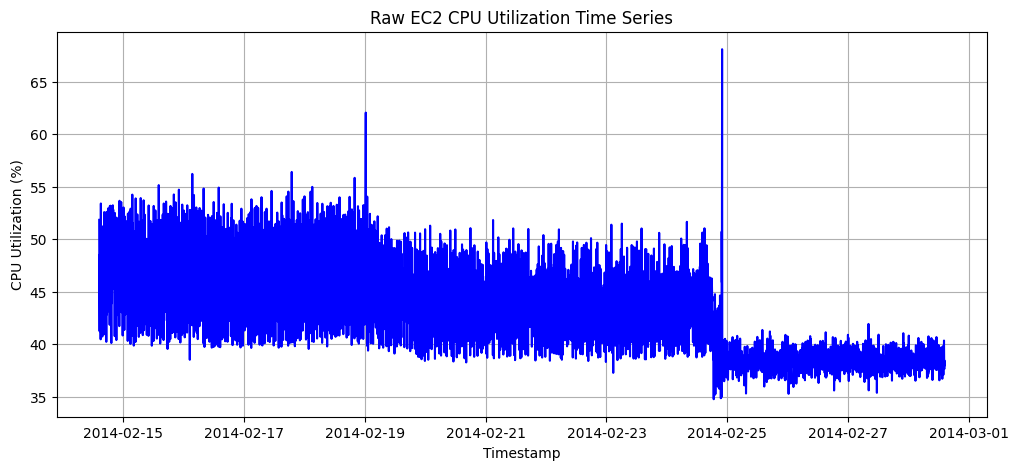

In [9]:
# Data Visualization

plt.figure(figsize=(12,5))
plt.plot(df.index, df['value'], color='blue')
plt.title("Raw EC2 CPU Utilization Time Series")
plt.xlabel("Timestamp")
plt.ylabel("CPU Utilization (%)")
plt.grid(True)
plt.show()

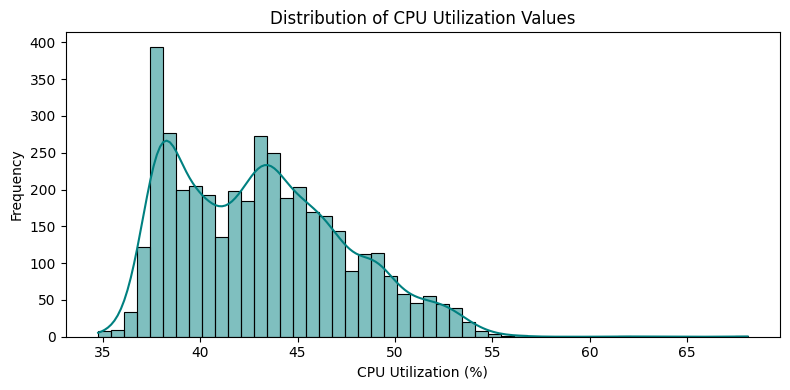

In [10]:
plt.figure(figsize=(8, 4))
sns.histplot(df['value'], bins=50, kde=True, color='teal')
plt.title("Distribution of CPU Utilization Values")
plt.xlabel("CPU Utilization (%)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Feature Engineering

In [11]:
rolling_window = 24
df['rolling_mean'] = df['value'].rolling(window=rolling_window).mean()
df['rolling_std'] = df['value'].rolling(window=rolling_window).std()

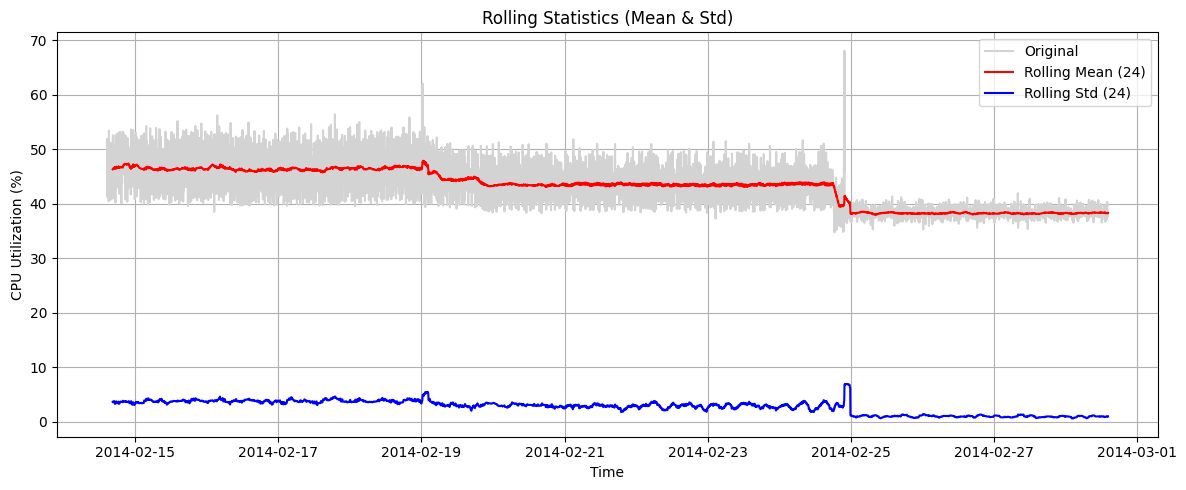

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['value'], color='lightgray', label='Original')
plt.plot(df.index, df['rolling_mean'], color='red', label=f'Rolling Mean ({rolling_window})')
plt.plot(df.index, df['rolling_std'], color='blue', label=f'Rolling Std ({rolling_window})')
plt.title("Rolling Statistics (Mean & Std)")
plt.xlabel("Time")
plt.ylabel("CPU Utilization (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Outlier Detection

In [13]:
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
outliers = df[(df['value'] < lower) | (df['value'] > upper)]
outliers

,value,rolling_mean,rolling_std
timestamp,,,
2014-02-16 03:27:00,56.220,46.744333,4.034386
2014-02-17 18:57:00,56.408,46.766500,4.627937
2014-02-19 00:22:00,62.056,47.725346,4.845193
2014-02-24 21:57:00,68.092,41.431917,6.855982


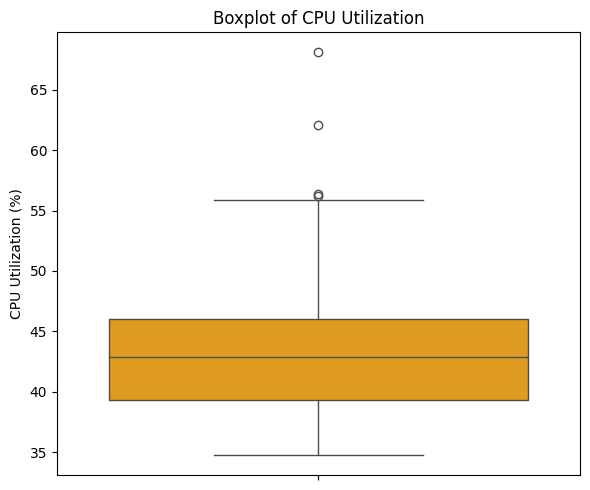

In [14]:
# Outliers Detection using Boxplot

plt.figure(figsize=(6, 5))
sns.boxplot(y=df['value'], color='orange')
plt.title("Boxplot of CPU Utilization")
plt.ylabel("CPU Utilization (%)")
plt.tight_layout()
plt.show()

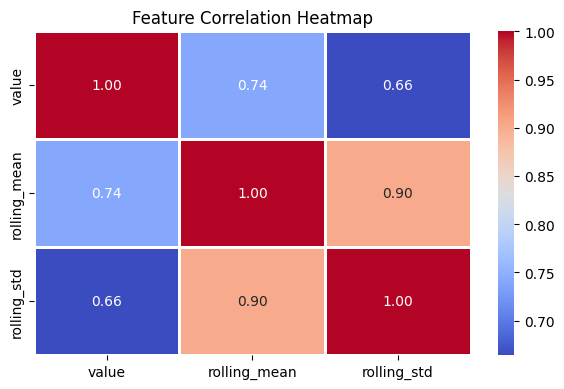

In [15]:
# Visualizing the Coorelation between features 

plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.75, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

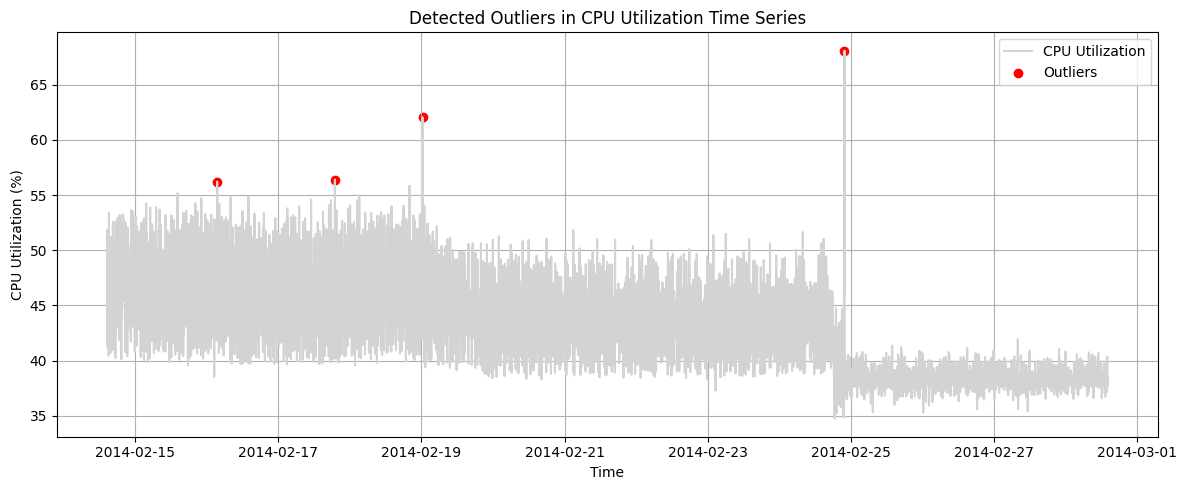

In [16]:
# Visualizing the Outliers

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['value'], label='CPU Utilization', color='lightgray')
plt.scatter(outliers.index, outliers['value'], color='red', label='Outliers')
plt.title("Detected Outliers in CPU Utilization Time Series")
plt.xlabel("Time")
plt.ylabel("CPU Utilization (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Handling Outliers

df_copy = df.copy()     # Creating a copy to avoid overwriting the original dataset
rolling_mean = df_copy['value'].rolling(window=rolling_window, min_periods=1).mean()
mask = (df_copy['value'] < lower) | (df_copy['value'] > upper)
df_copy.loc[mask, 'value'] = rolling_mean[mask]
print(f"Outliers replaced with rolling mean (window={rolling_window}).")

Outliers replaced with rolling mean (window=24).


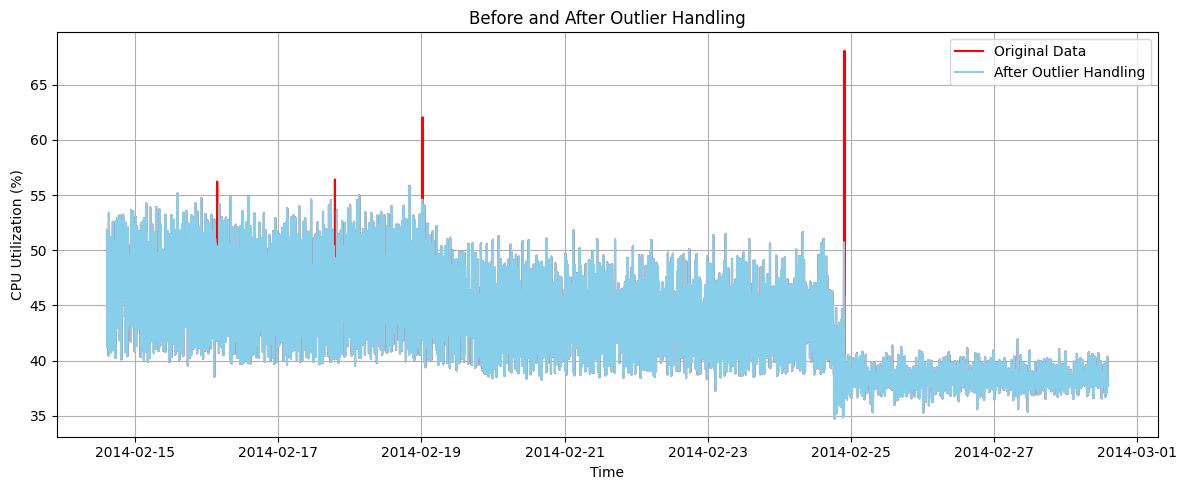

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['value'], label='Original Data', color='red')
plt.plot(df_copy.index, df_copy['value'], label='After Outlier Handling', color='skyblue')
plt.title("Before and After Outlier Handling")
plt.xlabel("Time")
plt.ylabel("CPU Utilization (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Feature Engineering

In [19]:
df_features = df_copy.copy()     # Creating a copy to avoid overwriting the original dataset

In [20]:
rolling_window = 10
df_features['rolling_mean'] = df_features['value'].rolling(window=rolling_window, min_periods=1).mean()
df_features['rolling_std'] = df_features['value'].rolling(window=rolling_window, min_periods=1).std()

In [21]:
df_features['lag_1'] = df_features['value'].shift(1)
df_features['lag_2'] = df_features['value'].shift(2)
df_features['lag_3'] = df_features['value'].shift(3)

In [22]:
df_features.dropna(inplace=True)

In [23]:
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_features[['value', 'rolling_mean', 'rolling_std', 'lag_1', 'lag_2', 'lag_3']])

In [24]:
df_scaled = pd.DataFrame(
    scaled_values,
    index=df_features.index,
    columns=['value', 'rolling_mean', 'rolling_std', 'lag_1', 'lag_2', 'lag_3']
)

In [25]:
df_scaled.head()

,value,rolling_mean,rolling_std,lag_1,lag_2,lag_3
timestamp,,,,,,
2014-02-14 14:42:00,1.283571,1.081749,1.566605,-0.433890,0.331210,2.050696
2014-02-14 14:47:00,0.848884,1.092598,1.052973,1.283589,-0.434300,0.330287
2014-02-14 14:52:00,0.443738,1.009263,0.750169,0.848826,1.283408,-0.434964
2014-02-14 14:57:00,1.410180,1.134917,0.622469,0.443610,0.848587,1.282163
2014-02-14 15:02:00,-0.615081,0.889606,0.971504,1.410219,0.443317,0.847489


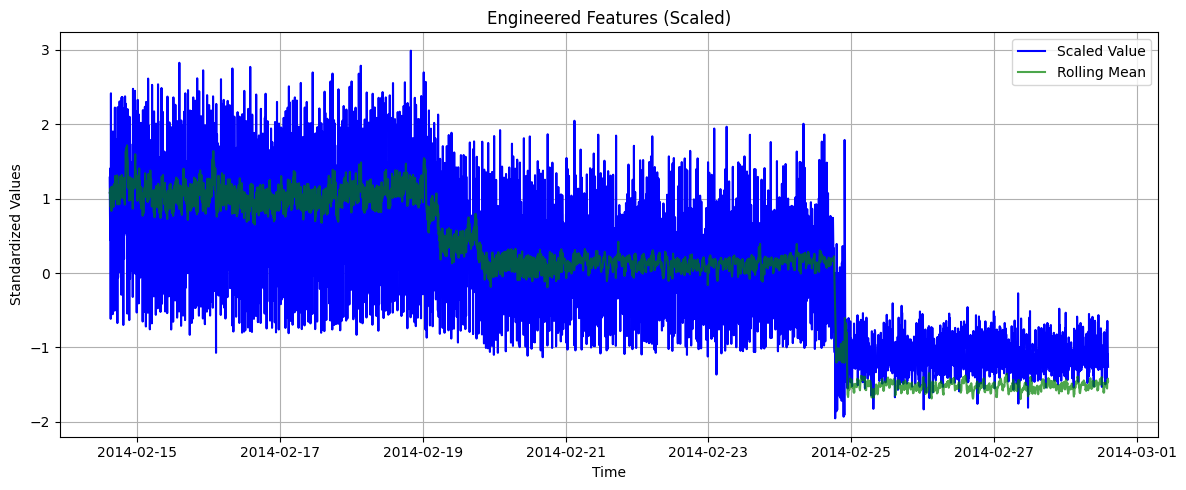

In [26]:
plt.figure(figsize=(12, 5))
plt.plot(df_scaled.index, df_scaled['value'], label='Scaled Value', color='blue')
plt.plot(df_scaled.index, df_scaled['rolling_mean'], label='Rolling Mean', color='green', alpha=0.7)
plt.title("Engineered Features (Scaled)")
plt.xlabel("Time")
plt.ylabel("Standardized Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### IsolationForest Model Training

In [27]:
X_scaled = df_scaled.copy()

In [28]:
model_iforest = IsolationForest(
    n_estimators=100,
    contamination=0.001,
    random_state=42
)

In [29]:
model_iforest.fit(X_scaled)

IsolationForest(contamination=0.001, random_state=42)

In [30]:
anomaly_scores = model_iforest.decision_function(X_scaled)
anomaly_labels = model_iforest.predict(X_scaled)

In [31]:
anomaly_labels = np.where(anomaly_labels == -1, 1, 0)

In [32]:
df_scaled['anomaly_score'] = anomaly_scores
df_scaled['anomaly'] = anomaly_labels

In [33]:
df_scaled['anomaly'].value_counts()

anomaly
0    4024
1       5
Name: count, dtype: int64

In [34]:
df_results = df_copy.copy().loc[df_scaled.index]
df_results['anomaly'] = df_scaled['anomaly']
df_results['anomaly_score'] = df_scaled['anomaly_score']

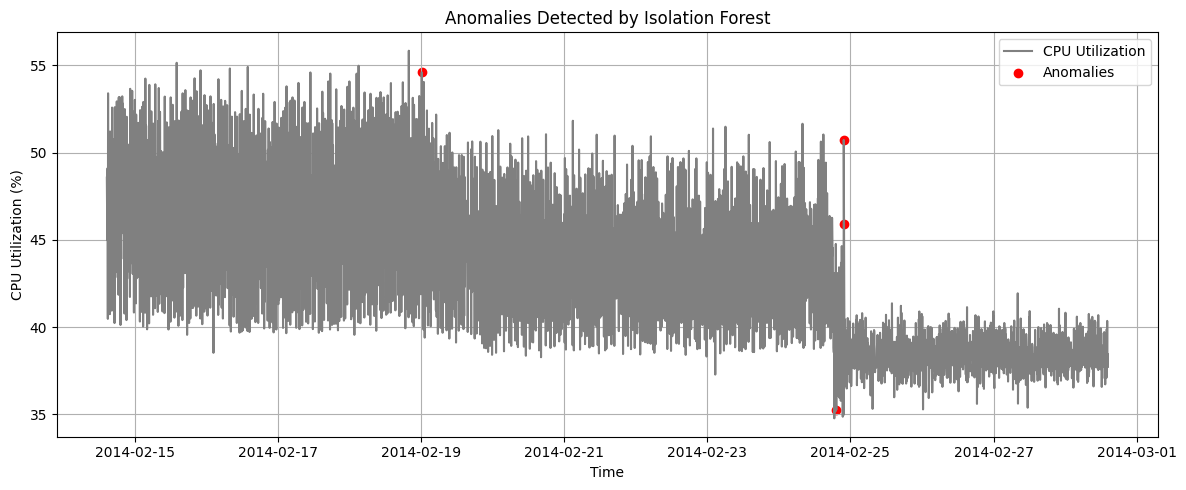

In [35]:
# Visualizing the Anamolies

plt.figure(figsize=(12, 5))
plt.plot(df_results.index, df_results['value'], label='CPU Utilization', color='gray')
plt.scatter(
    df_results.index[df_results['anomaly'] == 1],
    df_results['value'][df_results['anomaly'] == 1],
    color='red', label='Anomalies'
)
plt.title("Anomalies Detected by Isolation Forest")
plt.xlabel("Time")
plt.ylabel("CPU Utilization (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Evalutaing the IsolationForest Model

In [36]:
df_if_eval = df_results.copy()
df_if_eval['true_label'] = 0
df_if_eval.loc[df_if_eval.index.isin(outliers.index), 'true_label'] = 1

In [37]:
y_true_if = df_if_eval['true_label'].values
y_pred_if = df_if_eval['anomaly'].values

In [38]:
precision_if = precision_score(y_true_if, y_pred_if, zero_division=0)
recall_if = recall_score(y_true_if, y_pred_if, zero_division=0)
f1_if = f1_score(y_true_if, y_pred_if, zero_division=0)
roc_auc_if = roc_auc_score(y_true_if, y_pred_if)

In [39]:
print("Isolation Forest Evaluation Metrics")
print(f"Precision: {precision_if:.4f}")
print(f"Recall:    {recall_if:.4f}")
print(f"F1-Score:  {f1_if:.4f}")
print(f"AUC-ROC:   {roc_auc_if:.4f}")

Isolation Forest Evaluation Metrics
Precision: 0.2000
Recall:    0.2500
F1-Score:  0.2222
AUC-ROC:   0.6245


In [40]:
cm_if = confusion_matrix(y_true_if, y_pred_if)

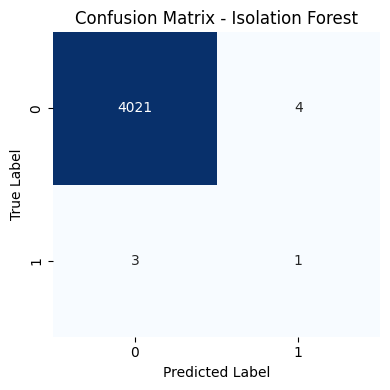

In [41]:
plt.figure(figsize=(4, 4))
sns.heatmap(cm_if, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Isolation Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### Training LSTM Model

In [42]:
X = df_scaled[['value', 'rolling_mean', 'rolling_std', 'lag_1', 'lag_2', 'lag_3']].values

In [43]:
timesteps = 10
X_seq = []
for i in range(len(X) - timesteps):
    X_seq.append(X[i:i+timesteps])
X_seq = np.array(X_seq)

In [44]:
train_size = int(0.7 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]

In [45]:
model_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(X_train.shape[1]),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2]))
])

C:\Users\Syed Zubair Yousuff\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [46]:
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 10, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 10, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 10, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 10, 6)               │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,134 (250.52 KB)

 Trainable params: 64,134 (250.52 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history = model_lstm.fit(
    X_train, X_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)

Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 33s 94ms/step - loss: 0.6690 - val_loss: 0.3431
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.4559 - val_loss: 0.3255
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.4198 - val_loss: 0.3209
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.4183 - val_loss: 0.3190
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.4141 - val_loss: 0.3161
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.4086 - val_loss: 0.3148
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.4096 - val_loss: 0.3172
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.4193 - val_loss: 0.3151
Epoch 9/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.3802 - val_loss: 0.3542
Epoch 10/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.3150 - val_loss: 0.1536
Epoch 11/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.1562 - val_loss: 0.1134
Epoch 12/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.

In [48]:
X_pred = model_lstm.predict(X_test)
reconstruction_error = np.mean(np.square(X_test - X_pred), axis=(1, 2))

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step


In [49]:
threshold = np.percentile(reconstruction_error, 99.5)
threshold

0.9902009199818818

In [50]:
anomaly_flags = (reconstruction_error > threshold).astype(int)

In [51]:
df_lstm = df_copy.iloc[-len(reconstruction_error):].copy()
df_lstm['recon_error'] = reconstruction_error
df_lstm['anomaly'] = anomaly_flags
df_lstm['anomaly'].value_counts()

anomaly
0    1199
1       7
Name: count, dtype: int64

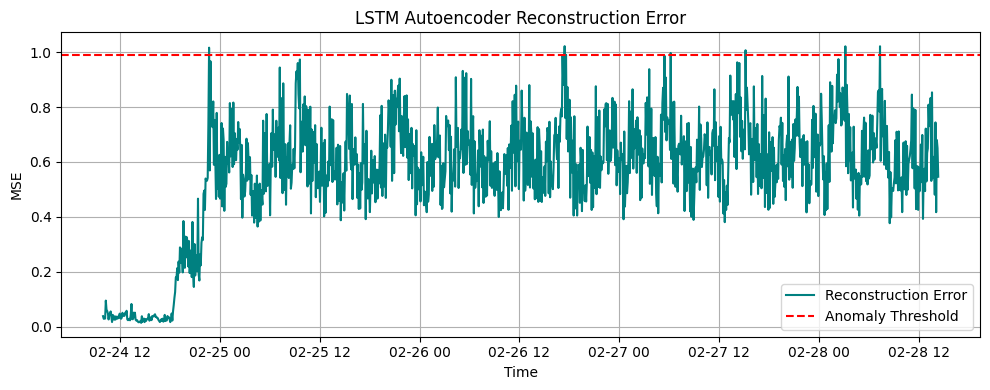

In [52]:
plt.figure(figsize=(10,4))
plt.plot(df_lstm.index, df_lstm['recon_error'], label='Reconstruction Error', color='teal')
plt.axhline(threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.title("LSTM Autoencoder Reconstruction Error")
plt.xlabel("Time")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

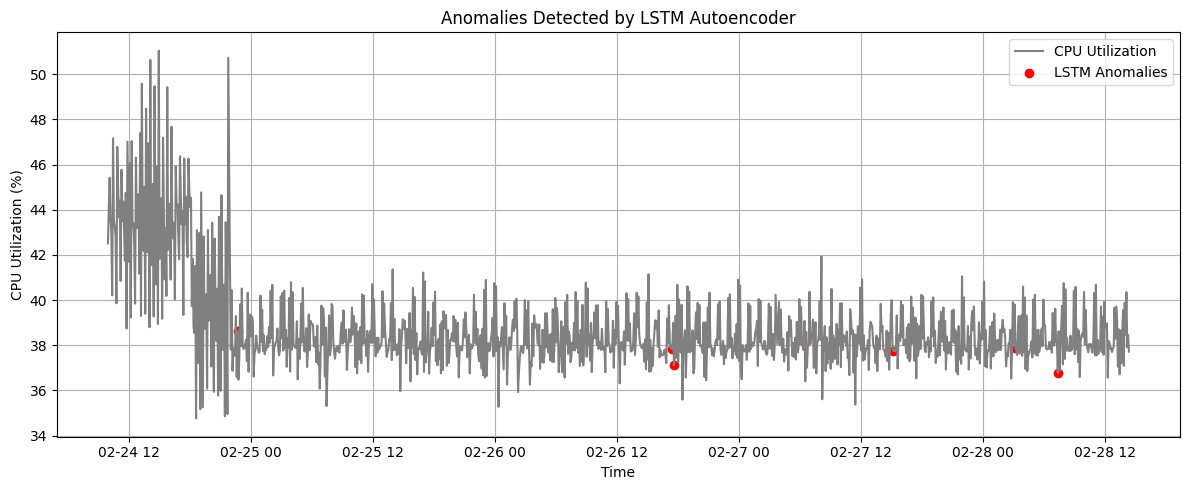

In [53]:
plt.figure(figsize=(12,5))
plt.plot(df_lstm.index, df_lstm['value'], color='gray', label='CPU Utilization')
plt.scatter(
    df_lstm.index[df_lstm['anomaly'] == 1],
    df_lstm['value'][df_lstm['anomaly'] == 1],
    color='red', label='LSTM Anomalies'
)
plt.title("Anomalies Detected by LSTM Autoencoder")
plt.xlabel("Time")
plt.ylabel("CPU Utilization (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Evaluating the LSTM Model

In [54]:
df_eval = df_lstm.copy()
df_eval['true_label'] = 0
df_eval.loc[df_eval.index.isin(outliers.index), 'true_label'] = 1
df_eval['true_label'].sum()

1

In [55]:
df_eval['anomaly'].sum()

7

In [56]:
y_true = df_eval['true_label'].values
y_pred = df_eval['anomaly'].values

In [57]:
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_true, y_pred)

In [58]:
print("Evaluation Metrics")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {roc_auc:.4f}")


Evaluation Metrics
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
AUC-ROC:   0.4971


In [59]:
cm = confusion_matrix(y_true, y_pred)

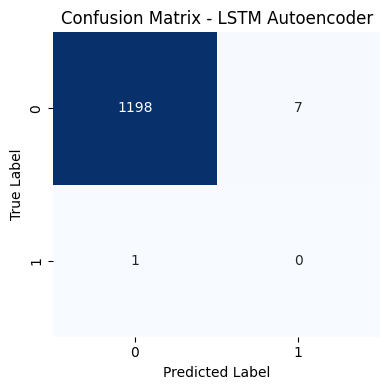

In [60]:
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - LSTM Autoencoder")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()